<a href="https://colab.research.google.com/github/Karthiksanthosh7025/Hexa/blob/master/Airline_Passenger_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, classification_report, f1_score

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup,
    BertModel,
    BertTokenizer,
    BertTokenizerFast,
    BertForSequenceClassification,
    AdamW
)

import collections
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
from google.colab import drive

#mount Google drive to Colab
drive.mount('/content/drive')

In [ ]:
#Importing the dataset
import pandas as pd

dataset_file_path = "/content/drive/MyDrive/Project 2023/Airline_review.csv"
#Reading Data and Loading contents in Dataframe
df = pd.read_csv(dataset_file_path)

In [ ]:
df.head()

In [ ]:
#Checking the number of rows and columns in dataset
df.shape

In [ ]:
#Checking for columns, their data types
df.info()

In [ ]:
#Checking count of unique values
col_counts = df.nunique()
print(col_counts)

In [ ]:
#Dropping Unnamed column since it does not convey anything
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
#Checking for duplicates
df.duplicated().value_counts()

In [ ]:
#Since there are duplicates identified which need to be dropped
#thus dropping duplicates
df= df.drop_duplicates()

In [ ]:
df.shape

In [ ]:
#Checking for null values count in columns
df.isnull().sum()

# **Exploratory Data Analysis**

In [ ]:
def extract_year(x):
    x = str(x)
    return x[-4:]

df['year_flown'] = df['Date Flown'].apply(extract_year)

df['year_flown'].value_counts().plot(kind="pie", autopct= '%1.1f%%')

In [ ]:
df['Type Of Traveller'].value_counts().plot(kind="pie", autopct= '%1.1f%%', startangle= 90)

In [ ]:
df['Seat Type'].value_counts().plot(kind="pie", autopct= '%1.1f%%')

In [ ]:
df['Overall_Rating'].value_counts().sort_index()

In [ ]:
rating_count= df['Overall_Rating'].value_counts().sort_index()
plt.bar(rating_count.index, rating_count.values, color= 'blue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Count of Ratings')

plt.show()

In [ ]:
df['Seat Type'].value_counts().sort_index()

In [ ]:
seat_type_count= df['Seat Type'].value_counts().sort_index()
plt.bar(seat_type_count.index, seat_type_count.values, color= 'blue')
plt.xlabel('Seat Type')
plt.ylabel('Count')
plt.title('Count of Seat Type')

plt.show()

In [ ]:
df['Seat Comfort'].value_counts().sort_index()

In [ ]:
seat_comfort_count= df['Seat Comfort'].value_counts().sort_index()
plt.bar(seat_comfort_count.index, seat_comfort_count.values, color= 'blue')
plt.xlabel('Seat Comfort')
plt.ylabel('Count')
plt.title('Count of Seat Comfort Ratings')

plt.show()

In [ ]:
df['Cabin Staff Service'].value_counts().sort_index()

In [ ]:
cabin_service_count= df['Cabin Staff Service'].value_counts().sort_index()
plt.bar(cabin_service_count.index, cabin_service_count.values, color= 'blue')
plt.xlabel('Cabin Staff Service')
plt.ylabel('Count')
plt.title('Count of Cabin Staff Service Ratings')

plt.show()

In [ ]:
fd_bev_count= df['Food & Beverages'].value_counts().sort_index()
fd_bev_count

In [ ]:
plt.bar(fd_bev_count.index, fd_bev_count.values, color= 'blue')
plt.xlabel('Food & Beverages Service')
plt.ylabel('Count')
plt.title('Count of Food & Beverages Service Ratings')

plt.show()

In [ ]:
Ground_Service_count= df['Ground Service'].value_counts().sort_index()
Ground_Service_count

In [ ]:
plt.bar(Ground_Service_count.index, Ground_Service_count.values, color= 'blue')
plt.xlabel('Ground Service')
plt.ylabel('Count')
plt.title('Count of Ground Service Ratings')

plt.show()

In [ ]:
Inflight_Entertainment_count= df['Inflight Entertainment'].value_counts().sort_index()
Inflight_Entertainment_count

In [ ]:
plt.bar(Inflight_Entertainment_count.index, Inflight_Entertainment_count.values, color= 'blue')
plt.xlabel('Inflight Entertainment')
plt.ylabel('Count')
plt.title('Count of Inflight Entertainment Ratings')

plt.show()

In [ ]:
Wifi_Connectivity_count= df['Wifi & Connectivity'].value_counts().sort_index()
Wifi_Connectivity_count

In [ ]:
plt.bar(Wifi_Connectivity_count.index, Wifi_Connectivity_count.values, color= 'blue')
plt.xlabel('Wifi & Connectivity')
plt.ylabel('Count')
plt.title('Count of Wifi & Connectivity Ratings')

plt.show()

In [ ]:
Value_For_Money_count= df['Value For Money'].value_counts().sort_index()
Value_For_Money_count

In [ ]:
plt.bar(Value_For_Money_count.index, Value_For_Money_count.values, color= 'blue')
plt.xlabel('Value For Money')
plt.ylabel('Count')
plt.title('Count of Value For Money Ratings')

plt.show()

In [ ]:
df['Recommended'].value_counts().plot(kind="pie", autopct= '%1.1f%%', startangle= 90)

# **Imputing Missing Values**

In [ ]:
#Dropping Airline name and Aircraft due to ethical considerations
df.drop(['Airline Name', 'Aircraft', 'Route', 'Date Flown', 'year_flown', 'Review Date', 'Verified'], axis=1, inplace=True)

In [ ]:
#Checking for null values count in columns
df.isnull().sum()

In [ ]:
#Forward-fill: Filling with previous valid value
df['Type Of Traveller'] = df['Type Of Traveller'].fillna(method='ffill')
df['Seat Type'] = df['Seat Type'].fillna(method='ffill')
df['Overall_Rating']=df['Overall_Rating'].replace('n',10)
df['Overall_Rating']=df['Overall_Rating'].astype(int)

In [ ]:
cols_to_be_imputed= ['Seat Comfort', 'Cabin Staff Service', 'Ground Service',
                     'Food & Beverages', 'Inflight Entertainment', 'Wifi & Connectivity',
                     'Value For Money']

imptr = KNNImputer(n_neighbors=5)

for i in cols_to_be_imputed:
  #Fetching column where value needs to be filled
  col = df[[i]].values.reshape(-1, 1)

  #Imputing values using KNN
  filled_vals = imptr.fit_transform(col)

  #Rounding off the filled values to the nearest integers and updating it in the original dataframe
  rounded_filled_vals = np.round(filled_vals)

  df[i] = rounded_filled_vals

In [ ]:
#Checking for null values count in columns
df.isnull().sum()

# **Mapping Categorical Column to Numeric Values**

In [ ]:
df['Recommended']=df['Recommended'].map({'no':0,'yes':1})

In [ ]:
#Encoding Categorical cols to Numeric cols except Review_Title and Review
enc_df = pd.get_dummies(df, columns=['Type Of Traveller'], prefix = ['Traveller_Type'],dtype=int)
enc_df=pd.get_dummies(enc_df, columns=['Seat Type'], prefix = ['Seat_Type'],dtype=int)

In [ ]:
enc_df.shape

In [ ]:
enc_df.head()

In [ ]:
#Finding Correlation excluding Review and Review_Title column
corr_enc_df= enc_df.drop(['Review_Title', 'Review'], axis=1)


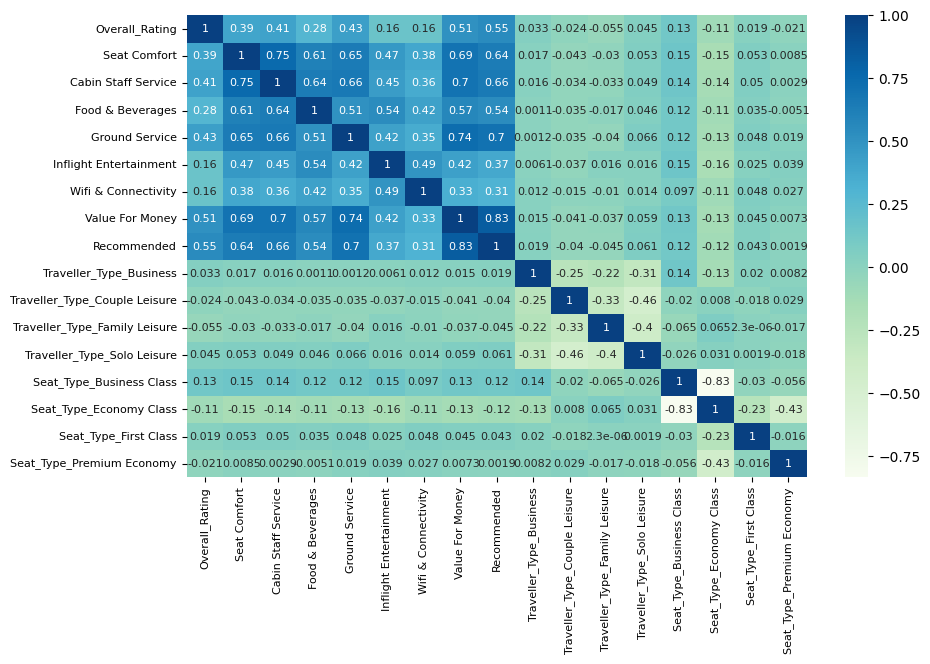

In [ ]:
#sns.heatmap(corr_enc_df.corr(), cmap="YlGnBu", annot=True)

plt.figure(figsize= (10,6))
sns.heatmap(corr_enc_df.corr(), annot=True, mask=None, cmap='GnBu', annot_kws={"fontsize":8})
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# **Text Pre-processing for ML Models**

In [ ]:
enc_df['Review']

0          Moroni to Moheli. Turned out to be a pretty ...
1         Moroni to Anjouan. It is a very small airline...
2          Anjouan to Dzaoudzi. A very small airline an...
3          Please do a favor yourself and do not fly wi...
4         Do not book a flight with this airline! My fr...
                               ...                        
23166     Bangkok to Tokyo. I’ve flown many low cost ai...
23167      Avoid at all costs. I booked flights to go f...
23168      Flight was leaving at 23.15 and after an hou...
23169     Zipair is JAL’s budget airline. They don’t ha...
23170      They lied about connection in Narita and we ...
Name: Review, Length: 23051, dtype: object

In [ ]:
enc_df['Review_Title']

0                       "pretty decent airline"
1                          "Not a good airline"
2                "flight was fortunately short"
3           "I will never fly again with Adria"
4         "it ruined our last days of holidays"
                          ...                  
23166            "customer service is terrible"
23167                      "Avoid at all costs"
23168            "Will not recommend to anyone"
23169               "It was immaculately clean"
23170    "lost all of our money with no refund"
Name: Review_Title, Length: 23051, dtype: object

The dataset contains two textual fields namely- Review and Review Title. Both of these fields will be pre-processed so that these can be used in ML models.

In [ ]:
stp_wds = stopwords.words(["english"])

In [ ]:
def pre_process(txt):
  txt = txt.lower().strip()
  clean_txt = "".join([i for i in txt if i not in string.punctuation])
  return clean_txt

enc_df['Review_Title'] = enc_df['Review_Title'].apply(lambda x: pre_process(x))
enc_df['Review'] = enc_df['Review'].apply(lambda x: pre_process(x))

In [ ]:
enc_df['Review_Title'] = enc_df['Review_Title'].apply(lambda x: ' '.join([wrd for wrd in x.split() if wrd not in (stp_wds) and wrd.isalpha()]))
enc_df['Review'] = enc_df['Review'].apply(lambda x: ' '.join([wrd for wrd in x.split() if wrd not in (stp_wds) and wrd.isalpha()]))


In [ ]:
enc_df['Review_Title']

In [ ]:
enc_df['Review']

0        moroni moheli turned pretty decent airline onl...
1        moroni anjouan small airline ticket advised tu...
2        anjouan dzaoudzi small airline airline based c...
3        please favor fly adria route munich pristina j...
4        book flight airline friend returned sofia amst...
                               ...                        
23166    bangkok tokyo flown many low cost airlines sti...
23167    avoid costs booked flights go singapore tokyo ...
23168    flight leaving hour half flying get back airpo...
23169    zipair budget airline classes travel pick seat...
23170    lied connection narita lost money refund agree...
Name: Review, Length: 23051, dtype: object

# **vectorisation**

In [ ]:
tf_idf=TfidfVectorizer()
review_vec = tf_idf.fit_transform(enc_df["Review"])
review_title_vec = tf_idf.fit_transform(enc_df["Review_Title"])

In [ ]:
review_vec

<23051x35091 sparse matrix of type '<class 'numpy.float64'>'
	with 1230490 stored elements in Compressed Sparse Row format>

# **Separating Inputs and Target Variable (Output)**

In [ ]:
X = enc_df.drop(columns=['Recommended'])
y = enc_df['Recommended']

In [ ]:
print('Shape of inputs: ', X.shape)
print('Shape of Output: ', y.shape)

Shape of inputs:  (23051, 18)
Shape of Output:  (23051,)


In [ ]:
#X currently contains textual columns- Review and Review Text which needs to be changed with TF-IDF vectors
sparse_num_data = csr_matrix(X.drop(columns=["Review","Review_Title"]).values)

# Horizontally Concatenating the sparse matrices and textual vectors
final_ftr_mtrx = hstack([sparse_num_data,review_vec, review_title_vec])

In [ ]:
type(final_ftr_mtrx)

scipy.sparse._csr.csr_matrix

# **Forming Train and Test Splits**

In [ ]:
#Splitting in the ratio of 75-25
X_train, X_test, y_train, y_test = train_test_split(final_ftr_mtrx, y, test_size=0.25,stratify=y, random_state=42)

In [ ]:
print('Shape of Training Inputs: ', X_train.shape)
print('Shape of Testing Inputs: ', X_test.shape)

print('Shape of Training Output: ', y_train.shape)
print('Shape of Testing Output: ', y_test.shape)

Shape of Training Inputs:  (17288, 39902)
Shape of Testing Inputs:  (5763, 39902)
Shape of Training Output:  (17288,)
Shape of Testing Output:  (5763,)


# **Predictive Model**

**Random Forest**

In [ ]:
#Loading Random Forest Model
rf_mdl = RandomForestClassifier()

#Training model
rf_mdl.fit(X_train, y_train)

#Predictions using Model
rf_mdl_y_pred = rf_mdl.predict(X_test)

print("Training Accuracy of Random Forest Model :", rf_mdl.score(X_train, y_train))
print("Testing Accuracy of Random Forest Model :", rf_mdl.score(X_test, y_test))


Training Accuracy of Random Forest Model : 1.0
Testing Accuracy of Random Forest Model : 0.9495054659031754


In [ ]:
#Generating Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_mdl_y_pred)

plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm_rf, cmap = 'Greens', annot = True, fmt = '.8g')

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

In [ ]:
#Generating Classification Report
cr_rf = classification_report(y_test, rf_mdl_y_pred)
print(cr_rf)

**Decision Tree**

In [ ]:
#Loading Decision Tree Model
dt_mdl = DecisionTreeClassifier()

#Training model
dt_mdl.fit(X_train, y_train)

#Predictions using Model
dt_mdl_y_pred = dt_mdl.predict(X_test)

print("Training Accuracy of Decision Tree Model :", dt_mdl.score(X_train, y_train))
print("Testing Accuracy of Decision Tree Model :", dt_mdl.score(X_test, y_test))

In [ ]:
#Generating Confusion Matrix
cm_dt = confusion_matrix(y_test, dt_mdl_y_pred)

plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm_dt, cmap = 'Greens', annot = True, fmt = '.8g')

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

In [ ]:
#Generating Classification Report
cr_dt = classification_report(y_test, dt_mdl_y_pred)
print(cr_dt)

**Logistic Regression**

In [ ]:
#Loading Logistic Regression Model
lr_mdl = LogisticRegression()

#Training model
lr_mdl.fit(X_train, y_train)

#Predictions using Model
lr_mdl_y_pred = lr_mdl.predict(X_test)

print("Training Accuracy of Logistic Regression Model :", lr_mdl.score(X_train, y_train))
print("Testing Accuracy of Logistic Regression Model :", lr_mdl.score(X_test, y_test))

In [ ]:
#Generating Confusion Matrix
cm_lr = confusion_matrix(y_test, lr_mdl_y_pred)

plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm_lr, cmap = 'Greens', annot = True, fmt = '.8g')

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

In [ ]:
#Generating Classification Report
cr_lr = classification_report(y_test, lr_mdl_y_pred)
print(cr_lr)

**XG Boost**

In [ ]:
#Loading XG Boost Model
xgb_mdl = xgb.XGBClassifier()

#Training model
xgb_mdl.fit(X_train, y_train)

#Predictions using Model
xgb_mdl_y_pred = xgb_mdl.predict(X_test)

print("Training Accuracy of Extreme Gradient Boost Model :", xgb_mdl.score(X_train, y_train))
print("Testing Accuracy of Extreme Gradient Boost Model :", xgb_mdl.score(X_test, y_test))

In [ ]:
#Generating Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_mdl_y_pred)

plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm_xgb, cmap = 'Greens', annot = True, fmt = '.8g')

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

In [ ]:
#Generating Classification Report
cr_xgb = classification_report(y_test, xgb_mdl_y_pred)
print(cr_xgb)

**AdaBoost Classifier**

In [ ]:
#Loading AdaBoost Model
ab_mdl = AdaBoostClassifier()

#Training model
ab_mdl.fit(X_train, y_train)

#Predictions using Model
ab_mdl_y_pred = ab_mdl.predict(X_test)

print("Training Accuracy of AdaBoost Classifier Model :", ab_mdl.score(X_train, y_train))
print("Testing Accuracy of AdaBoost Classifier Model :", ab_mdl.score(X_test, y_test))

In [ ]:
#Generating Confusion Matrix
cm_ab = confusion_matrix(y_test, ab_mdl_y_pred)

plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm_ab, cmap = 'Greens', annot = True, fmt = '.8g')

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

In [ ]:
#Generating Classification Report
cr_ab = classification_report(y_test, ab_mdl_y_pred)
print(cr_ab)

**Comparsion of Results**

In [ ]:
mdl_acc = {"Logistic Regression": lr_mdl.score(X_test, y_test),
           "Decision Tree":dt_mdl.score(X_test, y_test),
           "Random Forest":rf_mdl.score(X_test, y_test),
           "XG Boost":xgb_mdl.score(X_test, y_test),
           "AdaBoost":ab_mdl.score(X_test, y_test)}

print("Maximum Score obtained by Model: ", max(mdl_acc, key=mdl_acc.get))

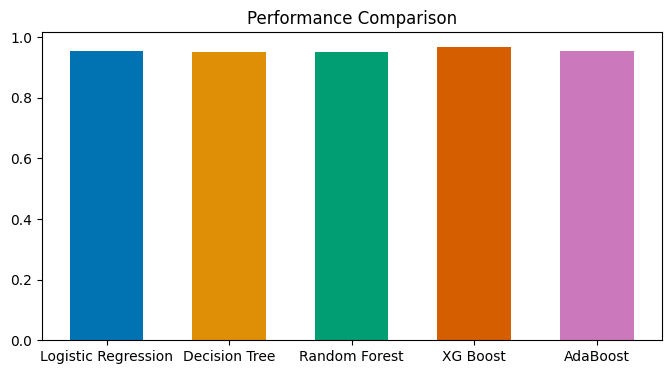

In [ ]:
clr_plt = sns.color_palette("colorblind")

plt.figure(figsize=(8,4))
plt.bar(*zip(*mdl_acc.items()), color=clr_plt, width = 0.6)
plt.title("Performance Comparison")
#plt.grid(axis = 'y', linewidth = 0.4)
plt.show()

# **BERT Model**

In [ ]:
df.head()

,Overall_Rating,Review_Title,Review,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,9,"""pretty decent airline""",Moroni to Moheli. Turned out to be a pretty ...,Solo Leisure,Economy Class,4.0,5.0,4.0,4.0,2.0,2.0,3.0,1
1,1,"""Not a good airline""",Moroni to Anjouan. It is a very small airline...,Solo Leisure,Economy Class,2.0,2.0,1.0,1.0,2.0,2.0,2.0,0
2,1,"""flight was fortunately short""",Anjouan to Dzaoudzi. A very small airline an...,Solo Leisure,Economy Class,2.0,1.0,1.0,1.0,2.0,2.0,2.0,0
3,1,"""I will never fly again with Adria""",Please do a favor yourself and do not fly wi...,Solo Leisure,Economy Class,1.0,1.0,3.0,1.0,2.0,2.0,1.0,0
4,1,"""it ruined our last days of holidays""",Do not book a flight with this airline! My fr...,Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


In [ ]:
df.shape

(23051, 13)

In [ ]:
bert_df= pd.DataFrame()
#bert_df['Review_Title'] = df['Review_Title']
bert_df['Review'] = df['Review']
bert_df['Recommended'] = df['Recommended']
bert_df.head()

,Review,Recommended
0,Moroni to Moheli. Turned out to be a pretty ...,1
1,Moroni to Anjouan. It is a very small airline...,0
2,Anjouan to Dzaoudzi. A very small airline an...,0
3,Please do a favor yourself and do not fly wi...,0
4,Do not book a flight with this airline! My fr...,0


In [ ]:
# Basic Data Cleaning- Remove HTML tags, punctuation
bert_df['Review'] = bert_df['Review'].str.replace('<[^<]+?>', '')
bert_df['Review'] = bert_df['Review'].str.replace('[^\w\s]','')

<ipython-input-180-c6891b13b2c1>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  bert_df['Review'] = bert_df['Review'].str.replace('<[^<]+?>', '')
<ipython-input-180-c6891b13b2c1>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  bert_df['Review'] = bert_df['Review'].str.replace('[^\w\s]','')


In [ ]:
bert_df.head()

,Review,Recommended
0,Moroni to Moheli Turned out to be a pretty d...,1
1,Moroni to Anjouan It is a very small airline ...,0
2,Anjouan to Dzaoudzi A very small airline and...,0
3,Please do a favor yourself and do not fly wi...,0
4,Do not book a flight with this airline My fri...,0


In [ ]:
#Preparing Training and Testing Data for Bert Model
#Shuffling Records first
bert_df = bert_df.sample(frac=1).reset_index(drop=True)

import collections as cl
#Splitting Dataset
rec = cl.defaultdict(list)
for i,j in bert_df.iterrows():
  rec[j.Recommended].append(j.to_dict())


#defining size
train = 0.75
val = 0.25
split_list = []

#shuffling and forming sets
for i,j in sorted(rec.items()):
  np.random.shuffle(j)

  n_tot = len(j)
  n_train = int(train * n_tot)
  n_val = int(val * n_tot)

  #Adding split attribute
  for item in j[:n_train]:
    item['split'] = 'train'

  for item in j[n_train:n_train+n_val]:
    item['split'] = 'val'


  split_list.extend(j)

new_bert_df = pd.DataFrame(split_list)



In [ ]:
new_bert_df.head()

In [ ]:
new_bert_df.groupby(['Recommended','split']).size().unstack(level=1)
a=new_bert_df.groupby(['Recommended','split']).size().unstack(level=1)
a.plot(kind='bar')

In [ ]:
#Separating Training and Testing Data
bert_df_train= new_bert_df[new_bert_df.split == 'train']
bert_df_test= new_bert_df[new_bert_df.split == 'val']

print('Shape of Training data: ', bert_df_train.shape)
print('Shape of Validation data: ', bert_df_test.shape)

In [ ]:
bert_df_train = bert_df_train.sample(frac=1).reset_index(drop=True)
bert_df_test = bert_df_test.sample(frac=1).reset_index(drop=True)

#Separating Review Text and Recommended Label
text_train = bert_df_train.Review.values
text_test = bert_df_test.Review.values

lbl_train = bert_df_train.Recommended.values
lbl_test = bert_df_test.Recommended.values

In [ ]:
#Text Preprocessing- Tokenisation using BERT Tokeniser
#Loading BERT Tokenizer
tknsr= BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#Creating input ids and attention masks
def text_prep(text):
  ip_id = []


  for txt in text:
    #prepend CLS token in beginning and SEP token in end
    #Mapping tokens to ids
    enc_txt = tknsr.encode(txt, add_special_tokens= True,
                           truncation = True, max_length = 50)

    ip_id.append(enc_txt) #storing all input ids

  #padding sequences
  ipt_ids = pad_sequences(ip_id, maxlen=50, dtype="long",
                            value=0, truncating="post", padding="post")

  #Attention Masks
  att_masks = []

  for i_text in ipt_ids:
    at_msk = [int(tokn_id > 0) for tokn_id in i_text]
    #if token id= 0, mask should be padded to 0
    #if token id is not zero, mask should be set to 1 since it is a real token

    att_masks.append(at_msk)

  return [ipt_ids, att_masks]





In [ ]:
ip_ids_train, att_masks_train = text_prep(text_train)
ip_ids_val, att_masks_val = text_prep(text_test)

In [ ]:
#Analysing Oroginal Text and pre-processed Text
print('Original Review: ', text_train[0])

#Tokens of text.
print('Tokenized Review: ', tknsr.tokenize(text_train[0]))

#Ids.
print('Token IDs: ', tknsr.convert_tokens_to_ids(tknsr.tokenize(text_train[0])))

In [ ]:
ip_ids_train.shape

In [ ]:
#Creating Data Loaders using Torch Tensors
train_inputs = torch.tensor(ip_ids_train)
val_inputs = torch.tensor(ip_ids_val)

train_masks = torch.tensor(att_masks_train)
val_masks = torch.tensor(att_masks_val)

train_labels = torch.tensor(lbl_train)
val_labels = torch.tensor(lbl_test)

#-----creating data loader-----
batch_size= 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
#Loading Bert model for Classification
mdl= BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", #Using the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, #Since The number of output labels is 2.
    output_attentions = False, # Whether the model returns attentions weights and hidden states.
    output_hidden_states = False
)

mdl= mdl.to(device)

In [ ]:
#Setting Up Scheduler, Optimiser- Model Parameters
optmsr = torch.optim.AdamW(mdl.parameters(), lr= 2e-5, eps= 1e-8)

epochs = 5

schdlr = get_linear_schedule_with_warmup(optmsr, num_warmup_steps=0,
                                         num_training_steps= len(train_dataloader)* epochs)

In [ ]:
#Setting up performance metrics
def f1_sc_fn(pred, lbls):
  flat_pred = np.argmax(pred, axis=1).flatten()
  flat_lbls = lbls.flatten()
  return f1_score(flat_lbls, flat_pred, average='weighted')


#lbl_dic = {'no':0,'yes':1}


In [ ]:
#Defining evaluating model
def evaluate(validation_dataloader):

    mdl.eval()

    tot_val_loss = 0
    pred_value, actual_value = [], []

    for btch in validation_dataloader:

        bach = tuple(b.to(device) for b in btch)

        inpt = {'input_ids':      bach[0],
                  'attention_mask': bach[1],
                  'labels':         bach[2],
                 }

        with torch.no_grad():
            opt = mdl(**inpt)

        los = opt[0]
        logts = opt[1]
        tot_val_loss += los.item()

        logts = logts.detach().cpu().numpy()
        lbl_ids = inpt['labels'].cpu().numpy()
        pred_value.append(logts)
        actual_value.append(lbl_ids)

    avg_val_loss = tot_val_loss/len(validation_dataloader)
    pred_value = np.concatenate(pred_value, axis=0)
    actual_value = np.concatenate(actual_value, axis=0)

    return avg_val_loss, pred_value, actual_value


In [ ]:
#Training and evaluating model
for epoch in tqdm(range(1, epochs+1)):
    mdl.train()
    tot_train_loss = 0
    prgres_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), disable=False, leave=False)

    for bach in prgres_bar:
        mdl.zero_grad()  #backward pass
        bach = tuple(bt.to(device) for bt in bach)
        #Unpack the inputs from dataloader
        inpt = {'input_ids':      bach[0],
                  'attention_mask': bach[1],
                  'labels':         bach[2],
                 }
        opt = mdl(**inpt) #forward pass

        los = opt[0]
        tot_train_loss += los.item()
        los.backward()   #backward pass to calculate gradients

        torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1.0)
        optmsr.step()
        schdlr.step()
        prgres_bar.set_postfix({'training_loss': '{:.3f}'.format(los.item()/len(bach))})

    torch.save(mdl.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    avg_train_loss = tot_train_loss/len(train_dataloader)
    tqdm.write(f'Training loss: {avg_train_loss}')

    #evaluating model
    validation_loss, mdl_pred, act_val = evaluate(val_dataloader)
    validation_f1 = f1_sc_fn(mdl_pred, act_val)
    tqdm.write(f'Validation loss: {validation_loss}')
    tqdm.write(f'F1 Score (Weighted): {validation_f1}')

In [ ]:
loss, mdl_pred, act_val = evaluate(val_dataloader)

In [ ]:
mdl_pred

In [ ]:
act_val

In [ ]:
print('Shape of True Values: ', act_val.shape)
print('Shape of Predicted Values: ', mdl_pred.shape)

In [ ]:
#Flattening predicted values to obtain classification report and confusion matrix
y_pred = np.argmax(mdl_pred, axis=1).flatten()
print(classification_report(act_val, y_pred))

In [ ]:
#Generating Confusion Matrix
cm_bert= confusion_matrix(act_val, y_pred)

plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm_bert, cmap = 'Greens', annot = True, fmt = '.8g')

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

In [ ]:
#Visualising Results
ipt_ids_list = []

for bach in val_dataloader:
    # Get input_ids tensor from the batch
    ipt_ids = bach[0]
    ipt_ids_list.append(ipt_ids)

txt=[]
for x in (ipt_ids_list):
  for y in x:
    tok=tknsr.convert_ids_to_tokens(y)
    txt.append(tok)

res_df=pd.DataFrame()
res_df['Actual Label']= act_val
res_df['Tokenised Text']=txt
res_df['predictions']= y_pred

res_df.head()